<a href="https://colab.research.google.com/github/IsaacAkintaro/aylesbury-estate-sold-house-prices/blob/main/Aylesbury_Estate_Polynomial_Regression_Project_Sold_House_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.model_selection import train_test_split

In [ ]:
# Load data
data = pd.read_csv('aylesbury_estate_prices_sold_prices.csv')
data.head(5)

,Date,Address,Postcode,Type,New-build,Tenure,Bedrooms,Price paid,Lat,Lng,URL
0,2023-03-22 00:00:00,"7, Chaucer Drive",SE1 5TA,Terraced house,Old stock,Freehold,1,365000,51.489845,-0.074342,https://propertydata.co.uk/transaction/FAC3076...
1,2023-03-06 00:00:00,"Flat 17, St. Johns House, Lytham Street",SE17 2PW,Flat,Old stock,Leasehold,2,330000,51.485108,-0.091103,https://propertydata.co.uk/transaction/FAC3076...
2,2023-03-03 00:00:00,"Flat 23, Knight House, Huntsman Street",SE17 1QN,Flat,Old stock,Leasehold,2,365000,51.490397,-0.085105,https://propertydata.co.uk/transaction/F87E72F...
3,2023-02-24 00:00:00,"26, Pilton Place",SE17 1DN,Flat,Old stock,Leasehold,2,335000,51.488718,-0.094106,https://propertydata.co.uk/transaction/F87E72F...
4,2023-02-24 00:00:00,"Flat 10, Bethersden House, Kinglake Estate",SE17 2LH,Flat,Old stock,Leasehold,3,355000,51.487997,-0.081331,https://propertydata.co.uk/transaction/FAC3076...


In [ ]:
# Convert 'Date' to datetime and extract year and month as new features
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month

# For 'Postcode', let's extract the area code which is the first part before the space
data['Area_Code'] = data['Postcode'].apply(lambda x: x.split(' ')[0])

# Dropping the 'Date', 'Address', 'Postcode', and 'URL' columns as we won't use them in the model
data.drop(['Date', 'Address', 'Postcode', 'URL'], axis=1, inplace=True)

# One-hot encoding and feature preparation
data = pd.get_dummies(data, drop_first=True)


X = data.drop(['Price paid'], axis=1)
y = np.log(data['Price paid'])  # Log-transform the Price paid


# Display the first few rows to verify the changes
data.head()

,Bedrooms,Price paid,Lat,Lng,Year,Month,Type_Flat,Type_Semi-detached house,Type_Terraced house,New-build_Old stock,Tenure_Leasehold,Area_Code_SE15,Area_Code_SE16,Area_Code_SE17,Area_Code_SE5
0,1,365000,51.489845,-0.074342,2023,3,False,False,True,True,False,False,False,False,False
1,2,330000,51.485108,-0.091103,2023,3,True,False,False,True,True,False,False,True,False
2,2,365000,51.490397,-0.085105,2023,3,True,False,False,True,True,False,False,True,False
3,2,335000,51.488718,-0.094106,2023,2,True,False,False,True,True,False,False,True,False
4,3,355000,51.487997,-0.081331,2023,2,True,False,False,True,True,False,False,True,False


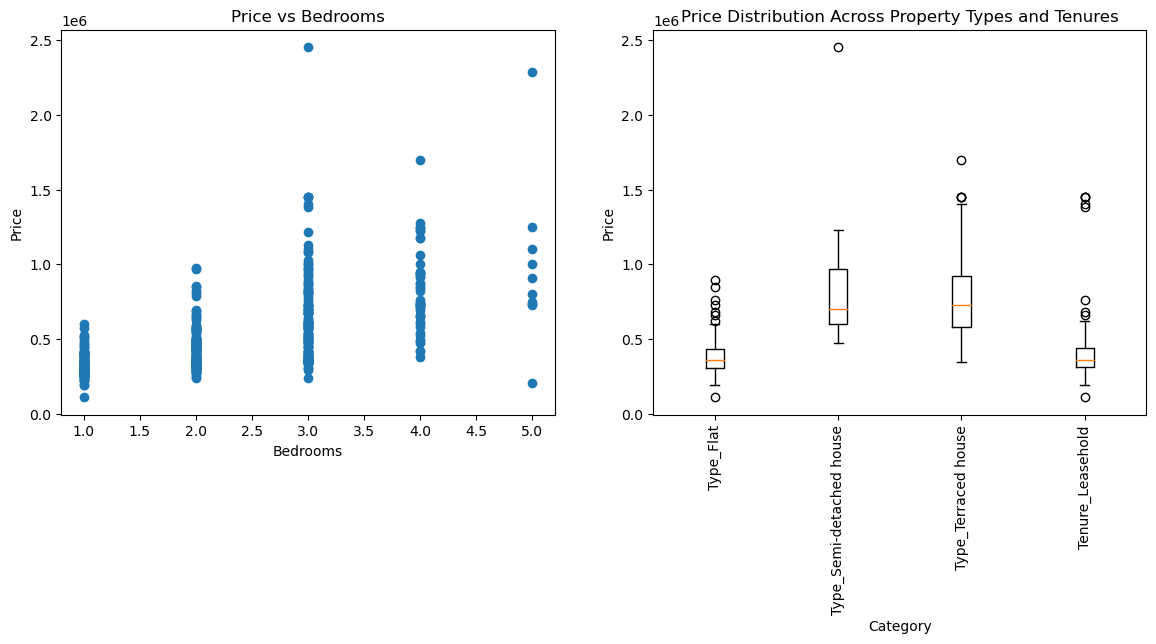

In [ ]:
# Visualize the features against the price
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Bedrooms vs Price
axs[0].scatter(data['Bedrooms'], np.exp(y))  # inverse log transform to original scale for visualization
axs[0].set_title('Price vs Bedrooms')
axs[0].set_xlabel('Bedrooms')
axs[0].set_ylabel('Price')

# One-hot encoded features vs Price
# Use box plots to show the distribution of prices for different property types and tenures
property_types = list(data.filter(regex='Type_').columns)
tenures = list(data.filter(regex='Tenure_').columns)

# Concatenate the property types and tenures for iteration
categories = property_types + tenures

for category in categories:
    # Create a boolean mask for each category
    mask = data[category] == 1
    # Apply the mask to the price and plot
    axs[1].boxplot(np.exp(y[mask]), positions=[categories.index(category)], labels=[category])

axs[1].set_title('Price Distribution Across Property Types and Tenures')
axs[1].set_xlabel('Category')
axs[1].set_ylabel('Price')
axs[1].tick_params(axis='x', rotation=90)  # Rotate x labels for better readability

plt.show()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state= 42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(258, 14) (173, 14) (258,) (173,)


In [ ]:
# Cross-validation setup for ElasticNetCV(Combines L1 and L2 Regression)
from sklearn.linear_model import ElasticNetCV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model = Pipeline([
    ('poly', PolynomialFeatures(degree=3)),
    ('ELasticNet', ElasticNetCV(cv = 5, random_state = 42))
])

# Train the model
model.fit(X_train, y_train)

# Evaluate it on the log-scale
print("Train Set", model.score(X_train, y_train))
print("Test Set",model.score(X_test, y_test))

# Perform cross-validation
cv_r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
cv_mse_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')

# Print cross-validation R² and MSE scores
print("Cross-validated R² scores:", cv_r2_scores)
print("Cross-validated MSE scores:", -cv_mse_scores)


Train Set 0.6903700382968276
Test Set 0.6797992633007621
Cross-validated R² scores: [0.76787968 0.67855838 0.65833229 0.64150918 0.71847203]
Cross-validated MSE scores: [0.05321792 0.06257123 0.05173789 0.06957418 0.0660305 ]


In [ ]:
# Cross-validation setup for ExtraTressRegressor:
from sklearn.ensemble import ExtraTreesRegressor
model_cv = Pipeline([
    ("poly", PolynomialFeatures(degree = 3)),
    ("ExtraTrees",ExtraTreesRegressor(n_estimators=100, random_state=42))
])

# Train the model
model_cv.fit(X_train,y_train)

# Evaluate it on the Log scale
print("Train Set", model_cv.score(X_train, y_train))
print("Test Set",model_cv.score(X_test, y_test))

# Perform cross-validation
cv_r2_scores = cross_val_score(model_cv, X, y, cv=kf, scoring='r2')
cv_mse_scores = cross_val_score(model_cv, X, y, cv=kf, scoring='neg_mean_squared_error')

# Print cross-validation R² and MSE scores
print("Cross-validated R² scores:", cv_r2_scores)
print("Cross-validated MSE scores:", -cv_mse_scores)

Train Set 0.9998623045213186
Test Set 0.7828199711985051
Cross-validated R² scores: [0.81187005 0.72815025 0.70837642 0.65542523 0.71191827]
Cross-validated MSE scores: [0.04313231 0.05291777 0.04415983 0.06687342 0.06756764]


In [ ]:
# Fit the model on the entire dataset for final evaluation and plotting
model.fit(X_train, y_train)
y_pred = model.predict(X)
y_pred = np.exp(y_pred)  # Inverse log transform
y_true = np.exp(y)  # Inverse log transform

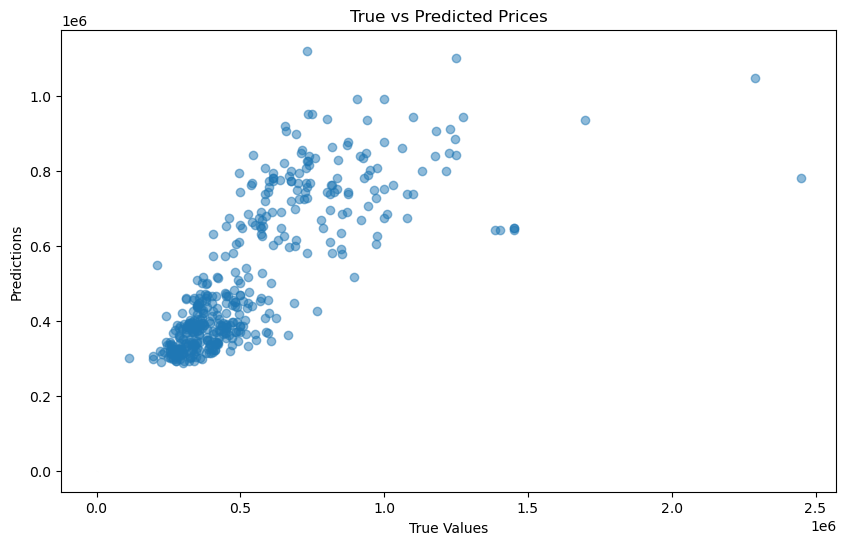

In [ ]:
# Plot Predicted vs True for the dataset
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)  # Diagonal line for reference
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Prices')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_log_error
# Final evaluation on the entire dataset
final_r2 = r2_score(y_true, y_pred)
final_mse = mean_squared_log_error(y_true, y_pred)
final_mae = median_absolute_error(y_true, y_pred)

print(f"Final R-squared: {final_r2}")
print(f"Final Mean Squared Error: {final_mse}")
print(f"Final Median Absolute Error: {final_mae}")


Final R-squared: 0.5740721287559618
Final Mean Squared Error: 0.06363772218146403
Final Median Absolute Error: 75140.37610859904


In [ ]:
# Determine the accuracy on the test set, Generalisation Error:
y_pred = model.predict(X_test)
y_pred = np.exp(y_pred)  # Inverse log transform
y_true = np.exp(y_test)  # Inverse log transform

# Final evaluation on the entire dataset
final_r2 = r2_score(y_true, y_pred)
final_mse = mean_squared_log_error(y_true, y_pred)
final_mae = median_absolute_error(y_true, y_pred)

print(f"Final Test R-squared: {final_r2}")
print(f"Final Test Mean Squared Error: {final_mse}")
print(f"Final Test Median Absolute Error: {final_mae}")

Final Test R-squared: 0.5752897024434873
Final Test Mean Squared Error: 0.06838317999500465
Final Test Median Absolute Error: 76309.52914307936


In [ ]:
# Fit the model on the entire dataset for final evaluation and plotting
model_cv.fit(X_train, y_train)
y_pred = model_cv.predict(X)
y_pred = np.exp(y_pred)  # Inverse log transform
y_true = np.exp(y)  # Inverse log transform

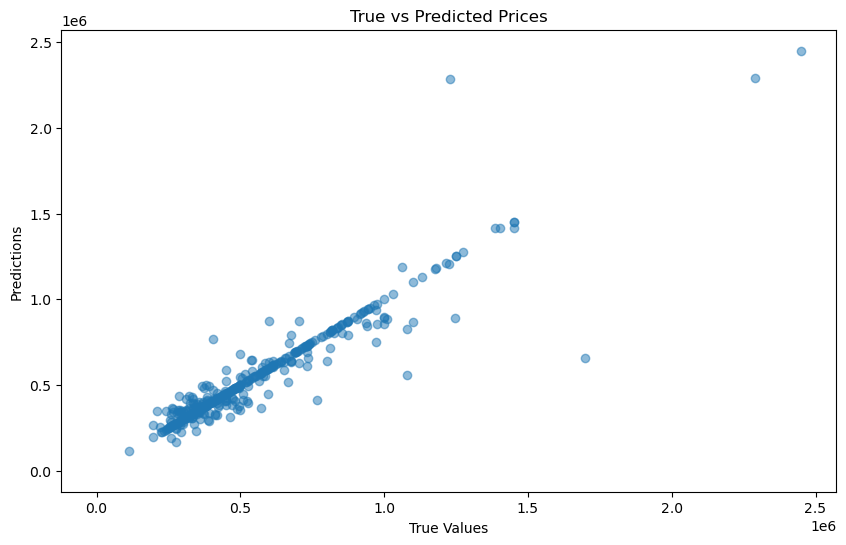

In [ ]:
# Plot Predicted vs True for the entire dataset
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)  # Diagonal line for reference
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Prices')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_log_error

# Final evaluation on the entire dataset
final_r2 = r2_score(y_true, y_pred)
final_mse = mean_squared_log_error(y_true, y_pred)
final_mae = median_absolute_error(y_true, y_pred)

print(f"Final R-squared: {final_r2}")
print(f"Final Mean Squared Error: {final_mse}")
print(f"Final Median Absolute Error: {final_mae}")

Final R-squared: 0.8859522157125009
Final Mean Squared Error: 0.01863333815505439
Final Median Absolute Error: 1.3154931366443634e-08


In [ ]:
# Determine the accuracy on the test set, Generalisation Error:

y_pred = model_cv.predict(X_test)
y_pred = np.exp(y_pred)  # Inverse log transform
y_true = np.exp(y_test)  # Inverse log transform

# Final evaluation on the entire dataset
final_r2 = r2_score(y_true, y_pred)
final_mse = mean_squared_log_error(y_true, y_pred)
final_mae = median_absolute_error(y_true, y_pred)

print(f"Final Test R-squared: {final_r2}")
print(f"Final Test Mean Squared Error: {final_mse}")
print(f"Final Test Median Absolute Error: {final_mae}")

Final Test R-squared: 0.7230856378735382
Final Test Mean Squared Error: 0.04638168985488929
Final Test Median Absolute Error: 50365.547781640314
